In [52]:
import gym
import sys
import numpy as np

from gym import error, spaces, utils
from copy import deepcopy

import matplotlib.pyplot as plt
import collections

from tqdm import tqdm

from collections import defaultdict

In [53]:
class CliffWalkingEnv(gym.Env):
    """
    A simplified implementation of the cliffwalking environment from 
    Sutton & Barto (e.g., Figure 6.13)

    The board is a 4x12 matrix, with (using NumPy matrix indexing):
        [3, 0] as the start at bottom-left
        [3, 11] as the goal at bottom-right
        [3, 1..10] as the cliff at bottom-center

    Each time step incurs -1 reward, and stepping into the cliff incurs -100 reward
    and a reset to the start. An episode terminates when the agent reaches the goal.
    """

    def observation(self, state):
        return state[0] * self.cols + state[1]

    def __init__(self, render_steps = False):
        self.env_shape = (4, 12) # attributes like these are added for convenience
        # (i.e., so it's easy to refer to these values in various methods)
        self.rows = 4
        self.cols = 12
        self.start = [3,0] # row, col of our start position
        self.goal = [3,11] # row, col of our terminal state
        self.current_state = self.start 
        self.render_steps = render_steps

        # Cliff location
        self._cliff = np.zeros(self.env_shape, dtype=np.bool)
        self._cliff[3, 1:-1] = True 

        # There are four actions: up, down, left and right
        # Note that the state space gym.spaces.Discrete is a custom class
        # in the gym library.
        self.action_space = spaces.Discrete(4)

        # observation is the x, y coordinate of the grid
        # Note the state space is the same custom class.
        self.observation_space = spaces.Discrete(self.rows*self.cols)


    def step(self, action):
        """
        Take a step in the cliffwalking environment.

        INPUT
          action : integer (0,3) : right (0), down (1), left (2), and up (3).
        OUTPUT
          observation : A special class representing the x,y on the grid.
          reward : float : The reward received following the action.
          terminal_state : boolean : Has the terminal state been reached?
        """
        new_state = deepcopy(self.current_state)

        if action == 0: #right, "min" ensures you can't go through a wall,
          # and just end up back in your previous state.
            new_state[1] = min(new_state[1]+1, self.cols-1)
        elif action == 1: #down, "max" ensures you can't go through a wall.
            new_state[0] = max(new_state[0]-1, 0)
        elif action == 2: #left
            new_state[1] = max(new_state[1]-1, 0)
        elif action == 3: #up
            new_state[0] = min(new_state[0]+1, self.rows-1)
        else:
            raise Exception("Invalid action.")

        # Update our state
        self.current_state = new_state

        if self.render_steps:
          self.render()

        reward = -1.0
        terminal_state = False
        if self.current_state[0] == 3 and self.current_state[1] > 0:
            if self.current_state[1] < self.cols - 1:
                reward = -100.0
                self.current_state = deepcopy(self.start)
            else:
                terminal_state = True

        # IMPORTANT: The step() method needs to return these 4 things in this order.
        # The new state, the reward, "is this episode over?" boolean", 
        # and an "info dictionary" for debugging purposes if you want to use it. 
        # I leave it empty.  
        return self.observation(self.current_state), reward, terminal_state, {}

    def reset(self):
        self.current_state = self.start
        return self.observation(self.current_state)
    
    def show_env(self):
      """
      Shows the environment.
      """
      gridworld = np.ndarray((self.rows,self.cols), dtype = 'object')

      for row in np.arange(self.rows):
        for col in np.arange(self.cols):

          if self.current_state == [row,col]:
            gridworld[row,col] = "x"
          elif [row,col] == self.goal:
              gridworld[row,col] = "T"
          elif self._cliff[row,col]:
              gridworld[row,col] = "C"
          else:
              gridworld[row,col] = "o"

      print(gridworld)


    def render(self, mode='human', close=False):
        self._render(mode, close)

    def _render(self, mode='human', close=False):
      """
      render function from:
      https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py

      I admit I don't have much experience with rendering with characters. On face,
      this works the same as what I made.
      """
      if close:
        return

      outfile = StringIO() if mode == 'ansi' else sys.stdout

      for s in range(self.rows*self.cols):
            position = np.unravel_index(s, self.env_shape)
            # print(self.s)
            if self.current_state == s:
                output = " x "
            elif position == (3,11):
                output = " T "
            elif self._cliff[position]:
                output = " C "
            else:
                output = " o "

            if position[1] == 0:
                output = output.lstrip() 
            if position[1] == self.env_shape[1] - 1:
                output = output.rstrip() 
                output += "\n"

            outfile.write(output)
      outfile.write("\n")

    def close(self):
        pass

In [54]:
class monte_carlo_agent(object):
    '''
    A first visit Monte Carlo agent with epsilon greedy policy
    '''
    def __init__(self, obs_n, act_n, epsilon, gamma):
        self.epsilon = epsilon
        self.act_n = act_n
        self.gamma = gamma

        self.total_return = defaultdict(lambda:0)
        self.num_visits = defaultdict(lambda:0)

        self.Q = np.random.rand(obs_n, act_n)

    def optimal_action(self, S):
        Q_values = self.Q[S]
        maxQ = np.max(self.Q[S])

        action = np.random.choice(np.where(Q_values == maxQ)[0])
        return action
    '''
    A epsilon greedy policy
    '''
    def policy(self, S):
        if np.random.uniform(0, 1) < (1.0 - self.epsilon):
            action = self.optimal_action(S)
        else:
            action = np.random.choice(self.act_n)

        return action

    def learn(self, states, actions, rewards):
        for step, state in enumerate(states):
            visited_rewards = rewards[step:]
            discounts = self.gamma ** np.arange(0, len(visited_rewards))

            action = actions[step]
            self.total_return[state, action] += sum(discounts * visited_rewards)
            self.num_visits[state, action] += 1
            self.Q[state, action] = self.total_return[state, action] / self.num_visits[state, action]
       

In [55]:
def run_episode(env, agent):
    trajectory = []
    S = env.reset()
    action = agent.policy(S)

    while(True):
        action = agent.policy(S)
        S_prime, reward, done, _ = env.step(action)
        trajectory.append((S, action, reward))

        S = S_prime

        if done:
            break
    
    return zip(*trajectory)

def main():
    env = CliffWalkingEnv()

    # I put epsilon = 0.2 here is because if i take epsilon = 0.1, It may take lots of time on episode 1.
    mc_agent = monte_carlo_agent(obs_n=env.observation_space.n,  act_n=env.action_space.n,  gamma = 0.8, epsilon=0.2)

    rewards_list = np.zeros(500)

    for episode in tqdm(range(500)):
        # print(episode)
        states, actions, rewards = run_episode(env, mc_agent)
        mc_agent.learn(states, actions, rewards)
        rewards_list[episode] = sum(rewards)

    return rewards_list

rl = main()

  1%|          | 3/500 [13:11<36:25:38, 263.86s/it]


KeyboardInterrupt: 

(-200.0, 0.0)

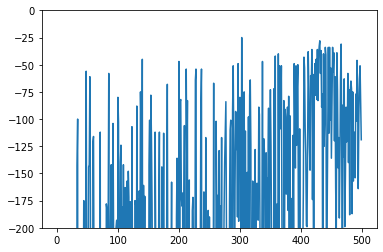

In [ ]:
plt.plot(range(0, 500), rl)
plt.ylim(-200,0)

In [ ]:
'''from collections import defaultdict
total_return = defaultdict(lambda:0)
num_visits = defaultdict(lambda:0)
Q= defaultdict(lambda:0)

t = [(1, 0, 3), (2, 0, 1), (2, 1, 1), (3, 0, 2)]
states, actions, rewards = zip(*t)

states, actions, rewards = zip(*t)
for step, state in enumerate(states):
    visited_rewards = rewards[step:]
    discounts = 0.8 ** np.arange(0, len(visited_rewards))

    action = actions[step]
    total_return[state, action] += discounts * sum(visited_rewards)
    num_visits[state] += 1
    Q[state, action] = total_return[state, action] / num_visits[state]


total_return'''

'from collections import defaultdict\ntotal_return = defaultdict(lambda:0)\nnum_visits = defaultdict(lambda:0)\nQ= defaultdict(lambda:0)\n\nt = [(1, 0, 3), (2, 0, 1), (2, 1, 1), (3, 0, 2)]\nstates, actions, rewards = zip(*t)\n\nstates, actions, rewards = zip(*t)\nfor step, state in enumerate(states):\n    visited_rewards = rewards[step:]\n    discounts = 0.8 ** np.arange(0, len(visited_rewards))\n\n    action = actions[step]\n    total_return[state, action] += discounts * sum(visited_rewards)\n    num_visits[state] += 1\n    Q[state, action] = total_return[state, action] / num_visits[state]\n\n\ntotal_return'